The focus of our project was the exploration and analysis of the COVID-19 Chest X-Ray dataset, sourced from a comprehensive compilation made available on GitHub (repository: [ieee8023/covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset). This dataset offers X-Ray images accompanied by relevant metadata, making it a valuable resource in the study of COVID-19.

Our objective was to develop a model capable of discerning patterns within these medical images. We started with a rudimentary model for this multi-label classification task, and subsequently transitioned to leveraging the power of ResNet50, a pretrained model. Over the course of the project, we refined our approach, implementing several iterations and modifications to better suit the intricacies of the data.

The analyses performed were geared towards enhancing model accuracy, with the end goal of creating a tool that could be valuable in the medical diagnostics realm, especially concerning COVID-19.

# Data Preparation

#### Data loading


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import torch
import torchvision

import os, random, torch, time, copy
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from PIL import Image, ImageOps, ImageFilter
from skimage.filters import threshold_local
from torchvision.transforms import Lambda


from torch.autograd import Variable

In [99]:
!pip -q install torchxrayvision

In [100]:
import torchxrayvision as xrv

In [101]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [102]:
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/", csvpath="covid-chestxray-dataset/metadata.csv")

In [103]:
sample = d[10]
print(d[1]["img"].shape)
sample

(1, 891, 880)


{'idx': 10,
 'lab': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1.], dtype=float32),
 'img': array([[[-269.05096, -301.17645, -317.2392 , ..., -678.651  ,
          -662.58826, -654.5569 ],
         [-180.70587, -204.79999, -244.95685, ..., -654.5569 ,
          -646.5255 , -638.49414],
         [-100.39215, -124.48627, -172.6745 , ..., -654.5569 ,
          -654.5569 , -646.5255 ],
         ...,
         [1024.     , 1024.     , 1024.     , ...,  855.3412 ,
           847.3098 ,  855.3412 ],
         [1024.     , 1024.     , 1024.     , ...,  839.27844,
           847.3098 ,  863.37256],
         [1024.     , 1024.     , 1024.     , ...,  847.3098 ,
           863.37256,  879.4353 ]]], dtype=float32)}

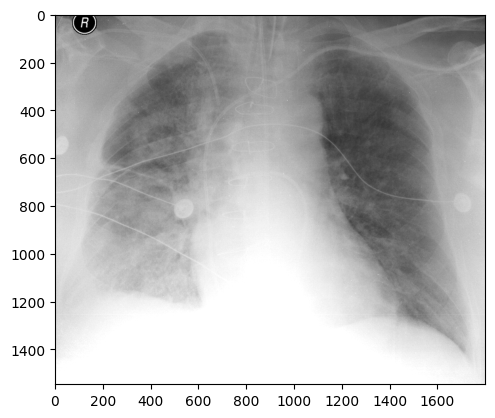

In [104]:
plt.imshow(sample["img"][0], cmap="gray");

In [105]:
pd.Series(dict(zip(d.pathologies,sample["lab"])))

Aspergillosis     0.0
Aspiration        0.0
Bacterial         0.0
COVID-19          0.0
Chlamydophila     0.0
Fungal            0.0
H1N1              0.0
Herpes            0.0
Influenza         0.0
Klebsiella        0.0
Legionella        0.0
Lipoid            0.0
MERS-CoV          0.0
MRSA              0.0
Mycoplasma        0.0
No Finding        0.0
Nocardia          0.0
Pneumocystis      0.0
Pneumonia         1.0
SARS              1.0
Staphylococcus    0.0
Streptococcus     0.0
Tuberculosis      0.0
Varicella         0.0
Viral             1.0
dtype: float32

In [106]:
d.csv.iloc[0]

index                                                                     0
patientid                                                                 2
offset                                                                  0.0
sex                                                                       M
age                                                                    65.0
finding                                            Pneumonia/Viral/COVID-19
RT_PCR_positive                                                           Y
survival                                                                  Y
intubated                                                                 N
intubation_present                                                        N
went_icu                                                                  N
in_icu                                                                    N
needed_supplemental_O2                                                    Y
extubated   

#### Data visualization

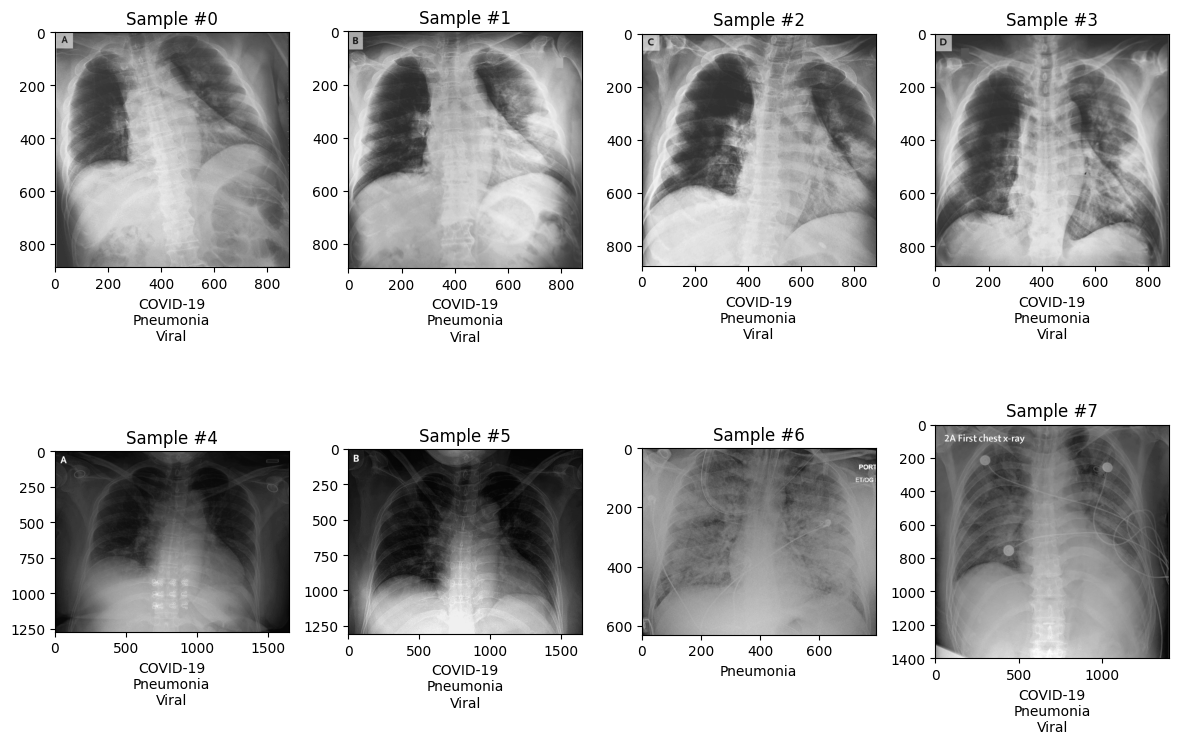

In [78]:
def visualize_dataset(dataset, num_images=8):
    if num_images > 8:
        print("Number of images exceeds the canvas size.")
        return

    fig = plt.figure(figsize=(12, 8))

    for i in range(num_images):
        sample = dataset[i]

        ax = plt.subplot(2, 4, i + 1)
        plt.tight_layout()
        ax.set_title("Sample #{}".format(i))
        plt.imshow(sample["img"][0], cmap='gray')  # `sample["img"][0]` retrieves the first channel of the image

        # Display diseases as the subtitle for the image
        disease_states = sample['lab'].astype(bool)
        diseases = [dataset.pathologies[j] for j, state in enumerate(disease_states) if state]
        ax.set_xlabel("\n".join(diseases))

    plt.show()

visualize_dataset(d)


#### Data augmentation

In [79]:
# Here we define random transformations to transform our data,
# however we don't change the size of the dataset, only substitute the original images

def basic_transformations():
    return transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(np.squeeze(np.uint8(x)), mode='L').convert('RGB')), # Convert numpy to RGB PIL
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),  # Convert to Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

d.transform = basic_transformations()

#### Splitting the data

In [81]:
split = [0.8, 0.1, 0.1]
dataset_size = len(d)
indicies = list(range(dataset_size))
np.random.shuffle(indicies)

train_split = int(float(split[0]) * dataset_size)
val_split = int(float(split[1]) * dataset_size)

train_indicies = indicies[:train_split]
val_indicies = indicies[train_split:train_split+val_split]
test_indicies = indicies[train_split+val_split:]

train_sample = SubsetRandomSampler(train_indicies)
val_sample = SubsetRandomSampler(val_indicies)
test_sample = SubsetRandomSampler(test_indicies)

#### Creating DataLoaders

In [82]:
batch_size = 32

train_loader = DataLoader(d, batch_size=batch_size, sampler=train_sample)
val_loader = DataLoader(d, batch_size=batch_size, sampler=val_sample)
test_loader = DataLoader(d, batch_size=batch_size, sampler=test_sample)

# Modeling

#### Defining a basic model

In [83]:
class CustomCNNClassificator(nn.Module):
  def __init__(self, num_classes):
    super(CustomCNNClassificator, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = nn.Linear(64 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    # Flattening the tensor
    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

num_pathologies = len(d.pathologies)
model_0 = CustomCNNClassificator(num_pathologies)

#### Training the model

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model_0.to(device)

In [88]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0

        for batch_data in self.train_loader:
            images = batch_data['img']
            labels = batch_data['lab']
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss

    def validate(self):
      self.model.eval()
      correct_samples = 0
      total_samples = 0

      with torch.no_grad():
          for batch_data in self.val_loader:
              images = batch_data['img'].to(self.device)
              labels = batch_data['lab'].to(self.device)
              outputs = self.model(images)
              predicted = torch.sigmoid(outputs) > 0.5
              correct_samples += (predicted == labels).all(dim=1).sum().item()
              total_samples += labels.size(0)

      accuracy = 100 * correct_samples / total_samples
      return accuracy

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            val_accuracy = self.validate()

            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model = self.model.to(self.device)

In [89]:
sample_data = next(iter(train_loader))
print(type(sample_data))
print(len(sample_data))
print(sample_data.keys())


<class 'dict'>
3
dict_keys(['idx', 'lab', 'img'])


In [90]:
# Instantiate the model and move it to the device
model = CustomCNNClassificator(num_pathologies).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Instantiate the trainer
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

# Train for a specified number of epochs
trainer.train(num_epochs=10)

# Save the model
trainer.save_model("simple_cnn_model.pth")

Epoch 1/10 - Loss: 0.1626, Validation Accuracy: 0.00%
Epoch 2/10 - Loss: 0.1087, Validation Accuracy: 64.15%
Epoch 3/10 - Loss: 0.1074, Validation Accuracy: 64.15%
Epoch 4/10 - Loss: 0.0988, Validation Accuracy: 60.38%
Epoch 5/10 - Loss: 0.0875, Validation Accuracy: 64.15%
Epoch 6/10 - Loss: 0.0659, Validation Accuracy: 47.17%
Epoch 7/10 - Loss: 0.0336, Validation Accuracy: 60.38%
Epoch 8/10 - Loss: 0.0123, Validation Accuracy: 41.51%
Epoch 9/10 - Loss: 0.0031, Validation Accuracy: 49.06%
Epoch 10/10 - Loss: 0.0014, Validation Accuracy: 43.40%


`Loss Progress:`

We observe a significant reduction in the loss value from the first to the tenth epoch, descending from 0.1626 to 0.0014. This suggests the model is successfully learning from the training data.

`Validation Accuracy:`

The accuracy on the validation set fluctuates and does not exhibit a clear upward trend. It peaks at 64.15% during the second and fifth epochs, but then decreases, ending at 43.40% in the tenth epoch.

`Potential Overfitting:`

Given the consistent decrease in loss but fluctuating validation accuracy, there's a hint of overfitting. By the 10th epoch, the model might be fitting too closely to the training data nuances, thereby performing less reliably on the validation set.

`Performance Relative to Dataset:`

An accuracy of 64.15% is a decent starting point given the simplicity of the model, especially when working with medical images which are inherently complex.

#### Moving to a pretrained model

In [91]:
import torchvision.models as models

class PretrainedModel:
    def __init__(self, num_classes, device):
        # Load a pretrained ResNet-50 model
        self.model = models.resnet50(pretrained=True)

        # Freeze the layers to avoid training them
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the final layer to match the number of classes
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

        self.model = self.model.to(device)

    def unfreeze_layers(self, num_layers):
        """Unfreeze the last num_layers of the model."""
        layers = list(self.model.children())[-num_layers:]  # Get the last num_layers
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = True

    def get_model(self):
        return self.model

In [92]:
# Instantiate the pretrained model class
pretrained = PretrainedModel(num_classes=num_pathologies, device=device)

# Optional: Unfreeze the last few layers for fine-tuning
pretrained.unfreeze_layers(2)

# Get the actual model to pass to the Trainer class
model = pretrained.get_model()

# Define the loss function and optimizer
# Note: Now we have to consider the parameters of the unfrozen layers only for optimization
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Instantiate the trainer
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

# Train for a specified number of epochs
trainer.train(num_epochs=10)

# Save the model
trainer.save_model("pretrained_resnet50_model.pth")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Epoch 1/10 - Loss: 0.1801, Validation Accuracy: 60.38%
Epoch 2/10 - Loss: 0.1243, Validation Accuracy: 58.49%
Epoch 3/10 - Loss: 0.1119, Validation Accuracy: 39.62%
Epoch 4/10 - Loss: 0.1041, Validation Accuracy: 43.40%
Epoch 5/10 - Loss: 0.0965, Validation Accuracy: 54.72%
Epoch 6/10 - Loss: 0.0942, Validation Accuracy: 56.60%
Epoch 7/10 - Loss: 0.0917, Validation Accuracy: 64.15%
Epoch 8/10 - Loss: 0.0898, Validation Accuracy: 52.83%
Epoch 9/10 - Loss: 0.0863, Validation Accuracy: 54.72%
Epoch 10/10 - Loss: 0.0834, Validation Accuracy: 52.83%


`Loss Progress:`

The loss gradually decreases from 0.1801 in the first epoch to 0.0834 by the tenth epoch. This continuous reduction suggests the model is learning and refining its predictions.

`Validation Accuracy:`

The accuracy on the validation set is quite volatile. The highest accuracy achieved is 64.15% during the seventh epoch, but it fluctuates considerably across epochs.

`Complexity:`

The ResNet-50 architecture is more complex than the CustomCNNClassificator. While the latter is a basic three-layer convolutional model, ResNet-50 is deeper and employs more advanced mechanisms.

`Performance:`

Both models peak around an accuracy of 64.15%, but the pretrained model shows less stability in its validation accuracy across epochs. However, considering the depth and complexity of ResNet-50, one might expect better performance, suggesting potential improvements.

`Overfitting:`

Both models exhibit signs of potential overfitting, as seen from the fluctuating validation accuracy.

#### Modified version with a pretrained NN



Let's apply several modifications to our model as follows:

`F1-Score Metric:`

An additional validation metric, the F1-Score, has been added to the validate function. F1-Score provides a balanced measure between precision and recall, and it is particularly useful when the dataset is imbalanced. Given the macro-average method, it computes the F1 separately for each class and then takes the average, treating all classes equally.

`Early Stopping:`

The train function now includes an early stopping mechanism based on validation accuracy. If there's no improvement in accuracy for a specified number of epochs (patience), the training stops to prevent potential overfitting.

`Dropout in Final Layer:`

A dropout layer with a rate of 0.5 has been added before the final fully connected layer. Dropout is a regularization technique to prevent overfitting by randomly zeroing out a fraction of the input units during training.

`Final Layer Composition:`

The final fully connected layer is now encapsulated within a nn.Sequential, which means additional layers and transformations could be added in the future if desired.

In [122]:
from sklearn.metrics import f1_score

class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0

        for batch_data in self.train_loader:
            images = batch_data['img']
            labels = batch_data['lab']
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss

    def validate(self):
      self.model.eval()
      correct_samples = 0
      total_samples = 0
      all_labels = []
      all_predictions = []

      with torch.no_grad():
          for batch_data in self.val_loader:
              images = batch_data['img'].to(self.device)
              labels = batch_data['lab'].to(self.device)
              outputs = self.model(images)
              predicted = torch.sigmoid(outputs) > 0.5
              correct_samples += (predicted == labels).all(dim=1).sum().item()
              total_samples += labels.size(0)

              all_labels.append(labels.cpu())
              all_predictions.append(predicted.cpu())

      all_labels = torch.cat(all_labels)
      all_predictions = torch.cat(all_predictions)
      avg_f1 = f1_score(all_labels.numpy(), all_predictions.numpy(), average='macro')
      print(f"Validation F1-Score: {avg_f1:.2f}")

      accuracy = 100 * correct_samples / total_samples
      return accuracy

    def train(self, num_epochs, patience=5):
        best_accuracy = 0.0
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            val_accuracy = self.validate()
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Early stopping
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print("Stopping early!")
                break

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model = self.model.to(self.device)

In [121]:
class PretrainedModel:
    def __init__(self, num_classes, device):
        # Load a pretrained ResNet-50 model
        self.model = models.resnet50(pretrained=True)

        # Freeze the layers to avoid training them
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the final layer to match the number of classes
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

        self.model = self.model.to(device)

    def unfreeze_layers(self, num_layers):
        """Unfreeze the last num_layers of the model."""
        layers = list(self.model.children())[-num_layers:]  # Get the last num_layers
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = True

    def get_model(self):
        return self.model

In [115]:
# Instantiate the pretrained model class
pretrained = PretrainedModel(num_classes=num_pathologies, device=device)

# Optional: Unfreeze the last few layers for fine-tuning
pretrained.unfreeze_layers(2)

# Get the actual model to pass to the Trainer class
model = pretrained.get_model()

# Define the loss function and optimizer
# Note: Now we have to consider the parameters of the unfrozen layers only for optimization
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Instantiate the trainer
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

# Train for a specified number of epochs
trainer.train(num_epochs=10)

# Save the model
trainer.save_model("pretrained_resnet50_model_modified.pth")

Validation F1-Score: 0.10
Epoch 1/10 - Loss: 0.1798, Validation Accuracy: 35.85%
Validation F1-Score: 0.11
Epoch 2/10 - Loss: 0.1253, Validation Accuracy: 73.58%
Validation F1-Score: 0.11
Epoch 3/10 - Loss: 0.1127, Validation Accuracy: 60.38%
Validation F1-Score: 0.11
Epoch 4/10 - Loss: 0.1058, Validation Accuracy: 73.58%
Validation F1-Score: 0.11
Epoch 5/10 - Loss: 0.1018, Validation Accuracy: 73.58%
Validation F1-Score: 0.11
Epoch 6/10 - Loss: 0.0987, Validation Accuracy: 73.58%
Validation F1-Score: 0.11
Epoch 7/10 - Loss: 0.0952, Validation Accuracy: 66.04%
Stopping early!


`Validation F1-Score:`

The F1-Score remains low at around 0.11 for all epochs. This suggests that, while the model might be achieving a decent accuracy, its precision and recall balance for individual classes might not be ideal.

`Validation Accuracy:`

The accuracy peaks at 73.58%, which is higher than both the previous custom CNN and the earlier ResNet-50 model. However, the early stopping mechanism terminates training at the seventh epoch due to a lack of improvement, suggesting possible convergence.

`Training Loss:`

The loss gradually decreases, similar to the previous iterations.

`Relative Performance:`

The modified ResNet-50 model achieves the highest peak validation accuracy (73.58%) compared to the previous models.
The addition of the dropout layer might have contributed to better generalization on the validation set.
Early stopping ensures efficient training by halting once no significant improvements are observed, saving computational resources and potentially preventing overfitting.
Despite higher accuracy, the consistent F1-Score of around 0.11 indicates potential class imbalance issues or challenges in correctly predicting all classes.

#### Further improvements

Let's make a few other improvements:

`Learning Rate Scheduler:`

A learning rate scheduler (StepLR) was added, which decreases the learning rate after a set number of epochs (step_size=5). This helps in refining the model as training progresses.

`Class Weights Calculation:`

Class weights were calculated to handle the imbalance in the dataset. The weights were computed faster and more efficiently than in the earlier version. The computed weights are used in the loss function (BCEWithLogitsLoss).

`Optimizer Changes:`

The learning rate was slightly reduced to 0.0001.
Weight decay (1e-4) was added to the optimizer to regularize and prevent overfitting.

In [138]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0

        for batch_data in self.train_loader:
            images = batch_data['img']
            labels = batch_data['lab']
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss

    def validate(self):
      self.model.eval()
      correct_samples = 0
      total_samples = 0
      all_labels = []
      all_predictions = []

      with torch.no_grad():
          for batch_data in self.val_loader:
              images = batch_data['img'].to(self.device)
              labels = batch_data['lab'].to(self.device)
              outputs = self.model(images)
              predicted = torch.sigmoid(outputs) > 0.5
              correct_samples += (predicted == labels).all(dim=1).sum().item()
              total_samples += labels.size(0)

              all_labels.append(labels.cpu())
              all_predictions.append(predicted.cpu())

      all_labels = torch.cat(all_labels)
      all_predictions = torch.cat(all_predictions)
      avg_f1 = f1_score(all_labels.numpy(), all_predictions.numpy(), average='macro')
      print(f"Validation F1-Score: {avg_f1:.2f}")

      accuracy = 100 * correct_samples / total_samples
      return accuracy

    # Modify the `train` method of the Trainer class:
    def train(self, num_epochs, patience=5):
        best_accuracy = 0.0
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            val_accuracy = self.validate()
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            # Add this line to step the scheduler
            scheduler.step()

            # Early stopping
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print("Stopping early!")
                break

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model = self.model.to(self.device)

In [139]:
# Faster Calculation of Class Weights
labels_list = []
for batch in train_loader:
    labels_list.append(batch['lab'])
all_labels = torch.cat(labels_list, dim=0)
positive_counts = all_labels.sum(0)
total_counts = len(all_labels)
negative_counts = total_counts - positive_counts

# Prevent zero division
positive_counts = positive_counts.clamp(min=1)
negative_counts = negative_counts.clamp(min=1)

# Calculate class weights
weights_for_1 = (1 / positive_counts) * total_counts / 2.0
weights = weights_for_1.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

# Instantiate the pretrained model class
pretrained = PretrainedModel(num_classes=num_pathologies, device=device)

# Optional: Unfreeze the last few layers for fine-tuning
pretrained.unfreeze_layers(2)

# Get the actual model to pass to the Trainer class
model = pretrained.get_model()

# Define the loss function and optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)

# Using a simpler LR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Instantiate the trainer
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

# Train for a specified number of epochs
trainer.train(num_epochs=10)

# Save the model
trainer.save_model("pretrained_resnet50_model_modified_further_last.pth")

Validation F1-Score: 0.11
Epoch 1/10 - Loss: 0.7633, Validation Accuracy: 47.17%
Validation F1-Score: 0.11
Epoch 2/10 - Loss: 0.7192, Validation Accuracy: 71.70%
Validation F1-Score: 0.11
Epoch 3/10 - Loss: 0.6990, Validation Accuracy: 73.58%
Validation F1-Score: 0.11
Epoch 4/10 - Loss: 0.6964, Validation Accuracy: 71.70%
Validation F1-Score: 0.11
Epoch 5/10 - Loss: 0.7001, Validation Accuracy: 67.92%
Validation F1-Score: 0.11
Epoch 6/10 - Loss: 0.6781, Validation Accuracy: 67.92%
Validation F1-Score: 0.11
Epoch 7/10 - Loss: 0.6563, Validation Accuracy: 69.81%
Validation F1-Score: 0.11
Epoch 8/10 - Loss: 0.6460, Validation Accuracy: 69.81%
Stopping early!


`Loss Values:`

The last model starts with a significantly higher loss value but seems to converge as epochs progress, suggesting that it's learning. However, the loss doesn't go down as low as the previous model.

`Validation Accuracy: `

Both models reach similar validation accuracies around 73.58% as their best values. However, the last model reaches that value quicker (by the 3rd epoch) but doesn't show a significant improvement afterward.

`F1 Score:`

The F1 scores remained consistently around 0.11 for both models, suggesting that the model's performance hasn't improved significantly in terms of precision and recall. This might suggest that some pathologies are still challenging to predict or the dataset imbalance is significantly affecting performance.

`Stopping Epoch:`

The latest model trained for one more epoch before early stopping. The previous model stopped after 7 epochs, while the last one stopped after 8.

# Conclusion


We began with a basic model, and then shifted to a pretrained ResNet50 for better results. After adjusting the ResNet50, we saw some improvements, but the results remain suboptimal.

Despite adding a learning rate scheduler and weight decay, performance boosts were minimal. The steady F1 score across models hints at potential issues, possibly related to our dataset or the choice of model.

Both models yielded comparable results, without one outshining the other significantly. Given the intricacies of medical imagery, classifications are challenging.

Looking forward, we should consider:

Applying varied data processing techniques.
Exploring alternative model structures.
Consulting with medical professionals for domain-specific insights.
In essence, we've made strides, but there's ample scope for enhancement.





